

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(50000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 08:45:06,360: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

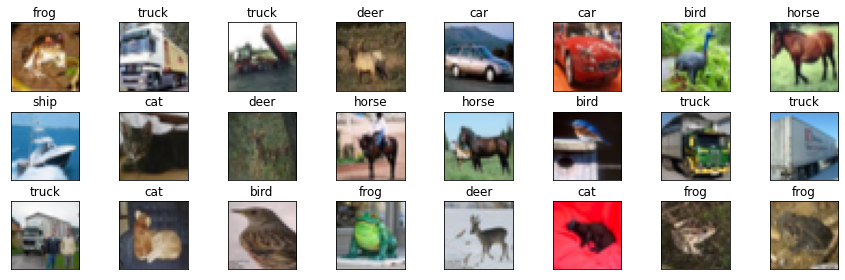

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

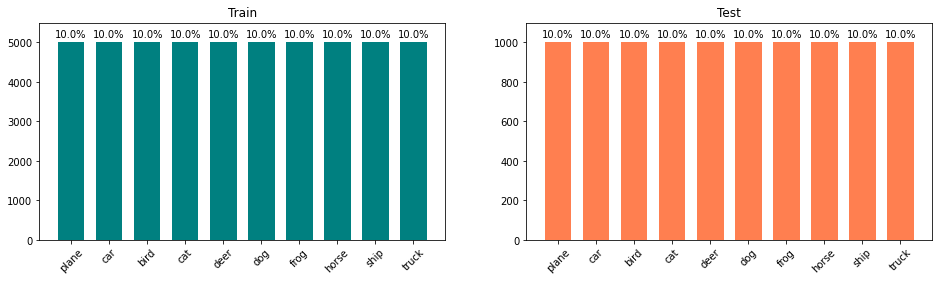

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

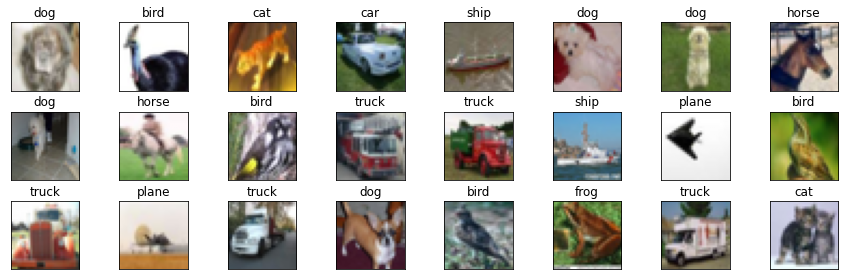

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

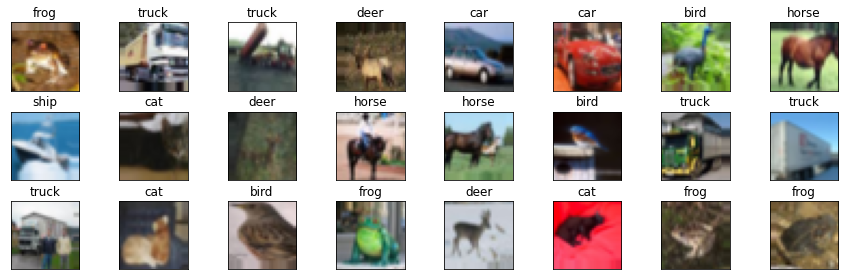

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

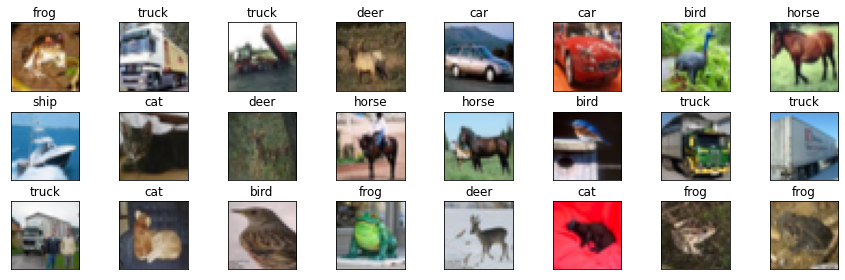

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


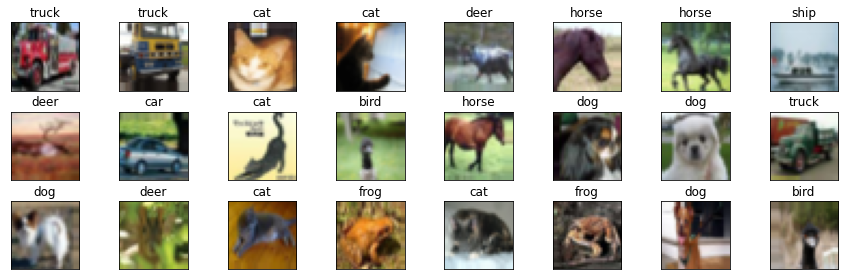

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 08:45:20,241: INFO: model_params.mlp1.dropout=0.1
2021-08-10 08:45:20,242: INFO: model_params.mlp1.layer_count=1
2021-08-10 08:45:20,243: INFO: model_params.mlp1.units=128
2021-08-10 08:45:20,309: INFO: learning_rate=0.001
2021-08-10 08:45:20,310: INFO: model_params.mlp1.clip_value=None
2021-08-10 08:45:20,331: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
2021-08-10 08:45:20,337: INFO: model_params.mlp1.epochs=120
2021-08-10 08:45:20,337: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1, monitor=val_accuracy)
2021-08-10 08:45:20,338: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:45:20,338: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:45:20,339: INFO: use LearningRateScheduler()
2021-08-10 08:45:20,

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1562/1562 [==============================] - 6s

2021-08-10 08:45:27,167: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 2/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.9449 - accuracy: 0.2727 - val_loss: 1.8952 - val_accuracy: 0.2979
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:45:32,204: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 3/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.9251 - accuracy: 0.2848 - val_loss: 1.8611 - val_accuracy: 0.3121
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:45:36,772: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 4/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.9190 - accuracy: 0.2865 - val_loss: 1.8555 - val_accuracy: 0.3142
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:45:41,917: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 5/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.9088 - accuracy: 0.2916 - val_loss: 1.8590 - val_accuracy: 0.3139
Epoch 6/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.9011 - accuracy: 0.2948 - val_loss: 1.8572 - val_accuracy: 0.3164
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:45:51,648: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 7/120
1562/1562 [==============================] - 5s 3ms/step - loss: 1.8981 - accuracy: 0.2980 - val_loss: 1.8465 - val_accuracy: 0.3196
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:45:57,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 8/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8989 - accuracy: 0.3000 - val_loss: 1.8478 - val_accuracy: 0.3182
Epoch 9/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8933 - accuracy: 0.3024 - val_loss: 1.8467 - val_accuracy: 0.3198
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:46:06,642: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 10/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8926 - accuracy: 0.3031 - val_loss: 1.8378 - val_accuracy: 0.3213
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:46:11,399: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 11/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8907 - accuracy: 0.3059 - val_loss: 1.8462 - val_accuracy: 0.3187
Epoch 12/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8904 - accuracy: 0.3077 - val_loss: 1.8519 - val_accuracy: 0.3200
Epoch 13/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8869 - accuracy: 0.3097 - val_loss: 1.8395 - val_accuracy: 0.3264
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:46:24,314: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 14/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8817 - accuracy: 0.3137 - val_loss: 1.8455 - val_accuracy: 0.3231
Epoch 15/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8808 - accuracy: 0.3127 - val_loss: 1.8361 - val_accuracy: 0.3324
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:46:33,202: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 16/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8840 - accuracy: 0.3126 - val_loss: 1.8373 - val_accuracy: 0.3237
Epoch 17/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8784 - accuracy: 0.3139 - val_loss: 1.8353 - val_accuracy: 0.3303
Epoch 18/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8749 - accuracy: 0.3181 - val_loss: 1.8336 - val_accuracy: 0.3339
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:46:46,113: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 19/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8758 - accuracy: 0.3182 - val_loss: 1.8431 - val_accuracy: 0.3265
Epoch 20/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8769 - accuracy: 0.3163 - val_loss: 1.8487 - val_accuracy: 0.3197
Epoch 21/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8755 - accuracy: 0.3190 - val_loss: 1.8423 - val_accuracy: 0.3271
Epoch 22/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8694 - accuracy: 0.3206 - val_loss: 1.8475 - val_accuracy: 0.3240
Epoch 23/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8709 - accuracy: 0.3186 - val_loss: 1.8456 - val_accuracy: 0.3240
Epoch 24/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8728 - accuracy: 0.3191 - val_loss: 1.8551 - val_accuracy: 0.3183
Epoch 25/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8693 - accuracy: 0.3191 - val_loss: 1.8415 -

2021-08-10 08:47:52,403: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 35/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8637 - accuracy: 0.3245 - val_loss: 1.8387 - val_accuracy: 0.3311
Epoch 36/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8640 - accuracy: 0.3242 - val_loss: 1.8400 - val_accuracy: 0.3307
Epoch 37/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8638 - accuracy: 0.3227 - val_loss: 1.8445 - val_accuracy: 0.3315
Epoch 38/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8633 - accuracy: 0.3249 - val_loss: 1.8362 - val_accuracy: 0.3343
Epoch 39/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8612 - accuracy: 0.3256 - val_loss: 1.8336 - val_accuracy: 0.3325
Epoch 40/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8604 - accuracy: 0.3262 - val_loss: 1.8354 - val_accuracy: 0.3359
Epoch 41/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8623 - accuracy: 0.3261 - val_loss: 1.8352 -

2021-08-10 08:48:33,185: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 45/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8550 - accuracy: 0.3285 - val_loss: 1.8388 - val_accuracy: 0.3321
Epoch 46/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8543 - accuracy: 0.3287 - val_loss: 1.8270 - val_accuracy: 0.3391
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:48:41,843: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 47/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8614 - accuracy: 0.3264 - val_loss: 1.8374 - val_accuracy: 0.3331
Epoch 48/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8590 - accuracy: 0.3289 - val_loss: 1.8402 - val_accuracy: 0.3352
Epoch 49/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8576 - accuracy: 0.3283 - val_loss: 1.8284 - val_accuracy: 0.3402
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:48:54,509: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 50/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8569 - accuracy: 0.3293 - val_loss: 1.8317 - val_accuracy: 0.3365
Epoch 51/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8590 - accuracy: 0.3266 - val_loss: 1.8221 - val_accuracy: 0.3466
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:49:03,216: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 52/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8540 - accuracy: 0.3298 - val_loss: 1.8386 - val_accuracy: 0.3329
Epoch 53/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8577 - accuracy: 0.3292 - val_loss: 1.8309 - val_accuracy: 0.3380
Epoch 54/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8606 - accuracy: 0.3259 - val_loss: 1.8324 - val_accuracy: 0.3395
Epoch 55/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8555 - accuracy: 0.3301 - val_loss: 1.8305 - val_accuracy: 0.3377
Epoch 56/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8532 - accuracy: 0.3297 - val_loss: 1.8364 - val_accuracy: 0.3357
Epoch 57/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8562 - accuracy: 0.3300 - val_loss: 1.8412 - val_accuracy: 0.3301
Epoch 58/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8535 - accuracy: 0.3281 - val_loss: 1.8329 -

2021-08-10 08:49:44,174: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 62/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8340 - accuracy: 0.3380 - val_loss: 1.8001 - val_accuracy: 0.3507
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:49:48,776: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 63/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8338 - accuracy: 0.3376 - val_loss: 1.7993 - val_accuracy: 0.3510
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:49:53,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 64/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8346 - accuracy: 0.3375 - val_loss: 1.8004 - val_accuracy: 0.3497
Epoch 65/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8359 - accuracy: 0.3368 - val_loss: 1.7999 - val_accuracy: 0.3510
Epoch 66/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8330 - accuracy: 0.3391 - val_loss: 1.7988 - val_accuracy: 0.3528
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-08-10 08:50:06,481: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 67/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8358 - accuracy: 0.3374 - val_loss: 1.8021 - val_accuracy: 0.3497
Epoch 68/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8320 - accuracy: 0.3384 - val_loss: 1.7993 - val_accuracy: 0.3517
Epoch 69/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8360 - accuracy: 0.3360 - val_loss: 1.8006 - val_accuracy: 0.3504
Epoch 70/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8331 - accuracy: 0.3387 - val_loss: 1.8005 - val_accuracy: 0.3512
Epoch 71/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8335 - accuracy: 0.3363 - val_loss: 1.8001 - val_accuracy: 0.3513
Epoch 72/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8375 - accuracy: 0.3372 - val_loss: 1.7994 - val_accuracy: 0.3522
Epoch 73/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8320 - accuracy: 0.3376 - val_loss: 1.8005 -

2021-08-10 08:51:24,236: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


Epoch 86/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8302 - accuracy: 0.3415 - val_loss: 1.7990 - val_accuracy: 0.3503
Epoch 87/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8298 - accuracy: 0.3396 - val_loss: 1.7993 - val_accuracy: 0.3506
Epoch 88/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8285 - accuracy: 0.3407 - val_loss: 1.7982 - val_accuracy: 0.3519
Epoch 89/120
1562/1562 [==============================] - 4s 2ms/step - loss: 1.8298 - accuracy: 0.3378 - val_loss: 1.8007 - val_accuracy: 0.3498
Epoch 90/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8315 - accuracy: 0.3395 - val_loss: 1.8002 - val_accuracy: 0.3498
Epoch 91/120
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
1562/1562 [==============================] - 4s 3ms/step - loss: 1.8294 - accuracy: 0.3396 - val_loss: 1.8009 - val_accuracy: 0.3513
Epoch 92/120
1562/1562 [====================

2021-08-10 08:53:46,489: INFO: finish training [elapsed time: 506.15 seconds]


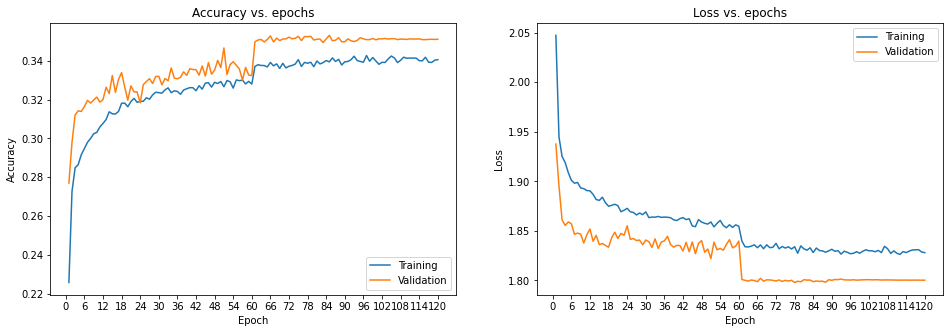

2021-08-10 08:53:47,075: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 08:53:55,908: INFO: test loss:1.7995
2021-08-10 08:53:55,909: INFO: test accuracy:0.3531
2021-08-10 08:53:55,911: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-10 08:53:55,913: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-10 08:53:55,914: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:53:55,915: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:53:55,916: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 08:54:01,075: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


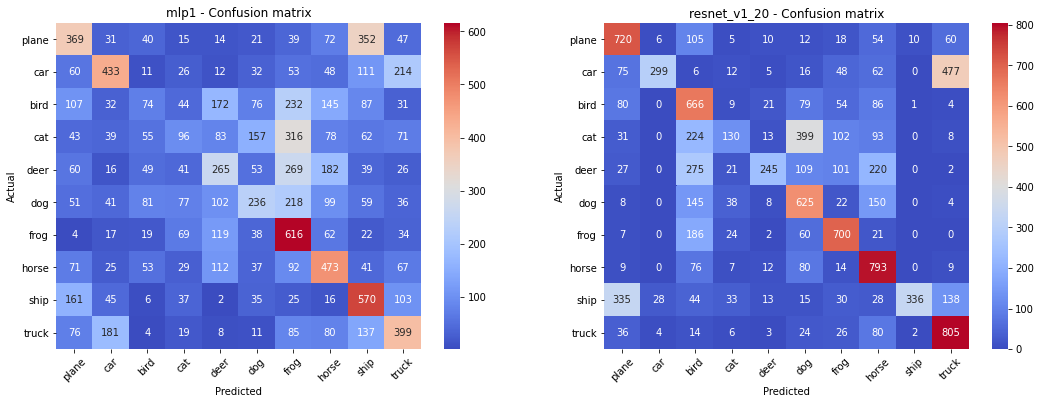

2021-08-10 08:54:07,598: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2021-08-10 08:54:12,995: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:54:12,997: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
2021-08-10 08:54:13,944: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:54:13,946: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
2021-08-10 08:54:14,958: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 08:54:14,960: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensor

2021-08-10 08:54:18,954: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f728669cb70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


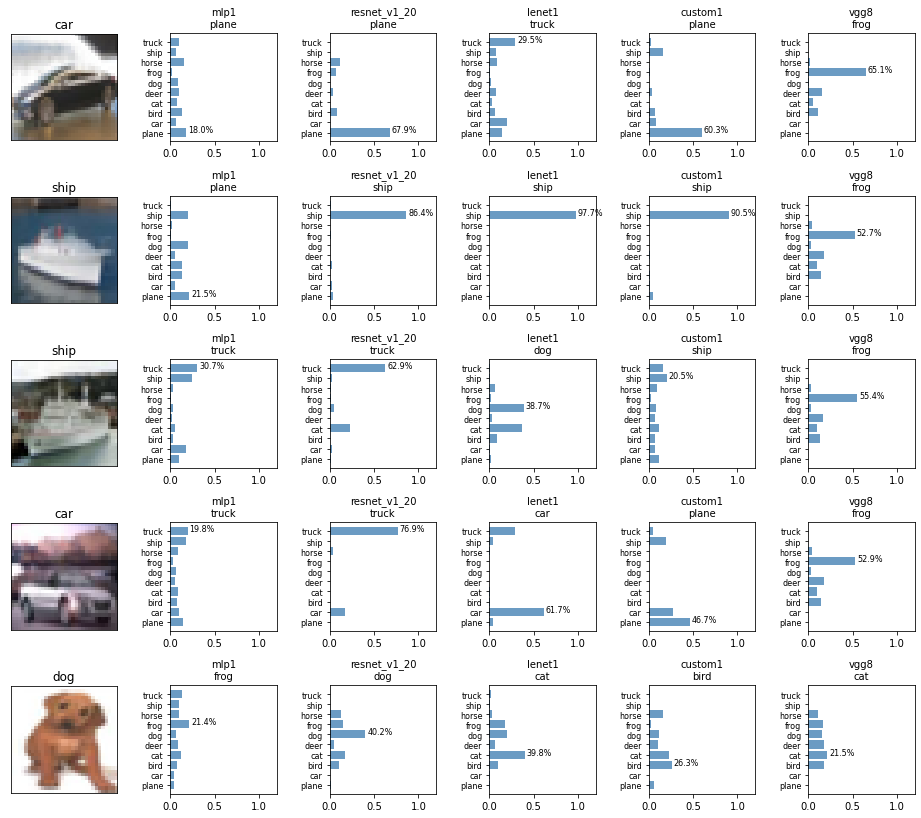

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,resnet_v1_20,273066,51.1,1.4243,1.4746,0.5483,0.5319,0.9320,0.9261
2,lenet1,83170,10.7,1.4288,1.4348,0.4971,0.4954,0.8874,0.8847
3,custom1,73738,12.4,1.4409,1.4617,0.4858,0.4729,0.8905,0.8868
4,mlp1,394634,505.6,1.7550,1.7995,0.3752,0.3531,0.8083,0.7939
5,vgg8,1672906,24.4,4.3419,4.3726,0.1832,0.1818,0.6803,0.6759


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 08:54:23,929: INFO: model_params.lenet1.dropout=0.2
2021-08-10 08:54:24,013: INFO: learning_rate=0.001
2021-08-10 08:54:24,014: INFO: model_params.lenet1.clip_value=None
2021-08-10 08:54:24,023: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
2021-08-10 08:54:24,029: INFO: model_params.lenet1.epochs=120
2021-08-10 08:54:24,030: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1, monitor=val_accuracy)
2021-08-10 08:54:24,031: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 08:54:24,032: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 08:54:24,033: INFO: use LearningRateScheduler()
2021-08-10 08:54:24,034: INFO: steps_per_epoch=1562
2021-08-10 08:54:24,034: INFO: start training
2021-08-10 08:54:24,035: INFO: use

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_______________________________________________________________

2021-08-10 08:54:35,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 2/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.4171 - accuracy: 0.4917 - val_loss: 1.5709 - val_accuracy: 0.4600
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:54:45,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 3/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.3091 - accuracy: 0.5359 - val_loss: 1.1830 - val_accuracy: 0.5809
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:54:55,556: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 4/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.2348 - accuracy: 0.5629 - val_loss: 1.1027 - val_accuracy: 0.6083
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:55:06,405: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 5/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1765 - accuracy: 0.5841 - val_loss: 1.0822 - val_accuracy: 0.6168
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:55:16,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 6/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1351 - accuracy: 0.6009 - val_loss: 1.2063 - val_accuracy: 0.5815
Epoch 7/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0953 - accuracy: 0.6147 - val_loss: 1.1298 - val_accuracy: 0.6004
Epoch 8/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0661 - accuracy: 0.6255 - val_loss: 1.0452 - val_accuracy: 0.6331
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:55:43,389: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 9/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0381 - accuracy: 0.6361 - val_loss: 1.0998 - val_accuracy: 0.6124
Epoch 10/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0233 - accuracy: 0.6434 - val_loss: 1.0767 - val_accuracy: 0.6283
Epoch 11/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.0010 - accuracy: 0.6473 - val_loss: 0.9691 - val_accuracy: 0.6648
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:56:10,095: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 12/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9854 - accuracy: 0.6540 - val_loss: 1.0749 - val_accuracy: 0.6366
Epoch 13/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9677 - accuracy: 0.6627 - val_loss: 0.8907 - val_accuracy: 0.6925
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:56:28,849: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 14/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9546 - accuracy: 0.6644 - val_loss: 0.9438 - val_accuracy: 0.6741
Epoch 15/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9471 - accuracy: 0.6689 - val_loss: 0.9187 - val_accuracy: 0.6830
Epoch 16/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9366 - accuracy: 0.6738 - val_loss: 1.1079 - val_accuracy: 0.6118
Epoch 17/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9307 - accuracy: 0.6746 - val_loss: 0.9544 - val_accuracy: 0.6679
Epoch 18/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9150 - accuracy: 0.6776 - val_loss: 0.9151 - val_accuracy: 0.6807
Epoch 19/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9099 - accuracy: 0.6798 - val_loss: 0.9326 - val_accuracy: 0.6753
Epoch 20/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9031 - accuracy: 0.6832 - val_loss: 1.0165 -

2021-08-10 08:57:53,705: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 24/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8739 - accuracy: 0.6936 - val_loss: 0.8544 - val_accuracy: 0.7041
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:58:03,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 25/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8716 - accuracy: 0.6930 - val_loss: 0.9216 - val_accuracy: 0.6795
Epoch 26/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8659 - accuracy: 0.6960 - val_loss: 0.9709 - val_accuracy: 0.6686
Epoch 27/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8573 - accuracy: 0.6982 - val_loss: 0.8214 - val_accuracy: 0.7156
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 08:58:30,076: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 28/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8499 - accuracy: 0.7012 - val_loss: 0.8855 - val_accuracy: 0.6952
Epoch 29/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8475 - accuracy: 0.7026 - val_loss: 0.8304 - val_accuracy: 0.7136
Epoch 30/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8444 - accuracy: 0.7039 - val_loss: 0.8620 - val_accuracy: 0.7020
Epoch 31/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8379 - accuracy: 0.7068 - val_loss: 0.9348 - val_accuracy: 0.6761
Epoch 32/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8369 - accuracy: 0.7059 - val_loss: 0.8771 - val_accuracy: 0.6971
Epoch 33/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8367 - accuracy: 0.7059 - val_loss: 0.8863 - val_accuracy: 0.6942
Epoch 34/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8296 - accuracy: 0.7083 - val_loss: 0.8361 -

2021-08-10 09:00:04,587: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 39/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8194 - accuracy: 0.7135 - val_loss: 0.8844 - val_accuracy: 0.7003
Epoch 40/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8149 - accuracy: 0.7136 - val_loss: 0.9626 - val_accuracy: 0.6720
Epoch 41/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8140 - accuracy: 0.7151 - val_loss: 0.7886 - val_accuracy: 0.7287
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 09:00:32,367: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 42/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8124 - accuracy: 0.7141 - val_loss: 0.8795 - val_accuracy: 0.6992
Epoch 43/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8075 - accuracy: 0.7141 - val_loss: 0.8602 - val_accuracy: 0.7071
Epoch 44/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8101 - accuracy: 0.7169 - val_loss: 0.9947 - val_accuracy: 0.6663
Epoch 45/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8018 - accuracy: 0.7188 - val_loss: 0.9124 - val_accuracy: 0.6856
Epoch 46/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7967 - accuracy: 0.7202 - val_loss: 0.8791 - val_accuracy: 0.7000
Epoch 47/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7926 - accuracy: 0.7218 - val_loss: 0.8312 - val_accuracy: 0.7133
Epoch 48/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7937 - accuracy: 0.7233 - val_loss: 0.8037 -

2021-08-10 09:02:49,468: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 58/120
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7446 - accuracy: 0.7395 - val_loss: 0.7918 - val_accuracy: 0.7298
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7415 - accuracy: 0.7395 - val_loss: 0.7941 - val_accuracy: 0.7268
Epoch 60/120
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7320 - accuracy: 0.7438 - val_loss: 0.7765 - val_accuracy: 0.7294
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7260 - accuracy: 0.7418 - val_loss: 0.8034 - val_accuracy: 0.7298
Epoch 62/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7242 - accuracy: 0.7450 - val_loss: 0.7766 - val_accuracy

2021-08-10 09:03:34,289: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 63/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7246 - accuracy: 0.7453 - val_loss: 0.7735 - val_accuracy: 0.7360
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 09:03:44,885: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 64/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7223 - accuracy: 0.7474 - val_loss: 0.7879 - val_accuracy: 0.7331
Epoch 65/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7190 - accuracy: 0.7476 - val_loss: 0.7891 - val_accuracy: 0.7288
Epoch 66/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7205 - accuracy: 0.7459 - val_loss: 0.7732 - val_accuracy: 0.7352
Epoch 67/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7121 - accuracy: 0.7486 - val_loss: 0.7611 - val_accuracy: 0.7389
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 09:04:20,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 68/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7113 - accuracy: 0.7486 - val_loss: 0.7614 - val_accuracy: 0.7373
Epoch 69/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7150 - accuracy: 0.7463 - val_loss: 0.8065 - val_accuracy: 0.7271
Epoch 70/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7160 - accuracy: 0.7475 - val_loss: 0.7591 - val_accuracy: 0.7401
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-08-10 09:04:48,348: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 71/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7083 - accuracy: 0.7522 - val_loss: 0.7839 - val_accuracy: 0.7337
Epoch 72/120
1562/1562 [==============================] - 9s 5ms/step - loss: 0.7056 - accuracy: 0.7521 - val_loss: 0.7682 - val_accuracy: 0.7384
Epoch 73/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7138 - accuracy: 0.7502 - val_loss: 0.7890 - val_accuracy: 0.7312
Epoch 74/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7126 - accuracy: 0.7471 - val_loss: 0.7778 - val_accuracy: 0.7355
Epoch 75/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7145 - accuracy: 0.7493 - val_loss: 0.7743 - val_accuracy: 0.7364
Epoch 76/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7055 - accuracy: 0.7536 - val_loss: 0.7741 - val_accuracy: 0.7371
Epoch 77/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7106 - accuracy: 0.7503 - val_loss: 0.7668 -

2021-08-10 09:07:48,385: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


Epoch 92/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6966 - accuracy: 0.7549 - val_loss: 0.7643 - val_accuracy: 0.7388
Epoch 93/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6998 - accuracy: 0.7542 - val_loss: 0.7671 - val_accuracy: 0.7381
Epoch 94/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7007 - accuracy: 0.7512 - val_loss: 0.7651 - val_accuracy: 0.7400
Epoch 95/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7000 - accuracy: 0.7531 - val_loss: 0.7634 - val_accuracy: 0.7389
Epoch 96/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.6955 - accuracy: 0.7551 - val_loss: 0.7653 - val_accuracy: 0.7389
Epoch 97/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6961 - accuracy: 0.7564 - val_loss: 0.7659 - val_accuracy: 0.7388
Epoch 98/120
1562/1562 [==============================] - 11s 7ms/step - loss: 0.7013 - accuracy: 0.7528 - val_loss: 0.7643 

2021-08-10 09:12:43,489: INFO: finish training [elapsed time: 1099.45 seconds]


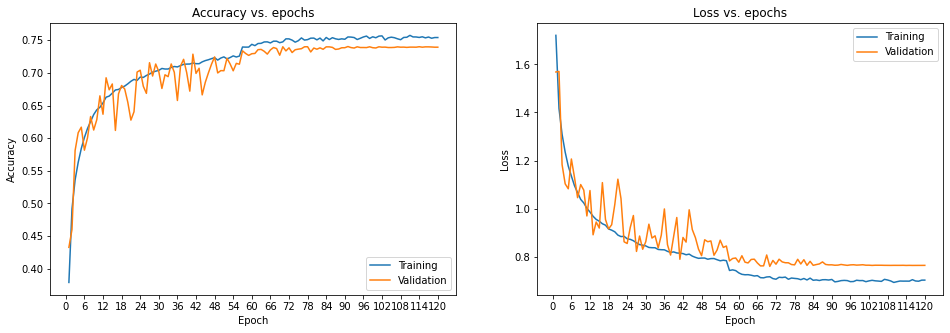

2021-08-10 09:12:44,037: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 09:12:58,012: INFO: test loss:0.7639
2021-08-10 09:12:58,013: INFO: test accuracy:0.7404
2021-08-10 09:12:58,015: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-10 09:12:58,016: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-10 09:12:58,017: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 09:12:58,018: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 09:12:58,018: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 09:13:03,244: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


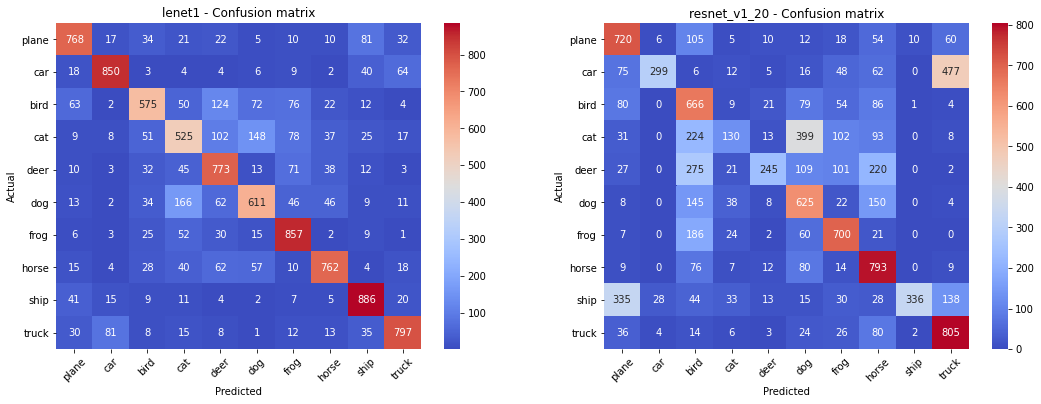

2021-08-10 09:13:09,141: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2021-08-10 09:13:14,861: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 09:13:14,862: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
2021-08-10 09:13:15,904: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 09:13:15,907: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
2021-08-10 09:13:16,224: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-08-10 09:13:16,226: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorfl

2021-08-10 09:13:19,909: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f72fc5e8730> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


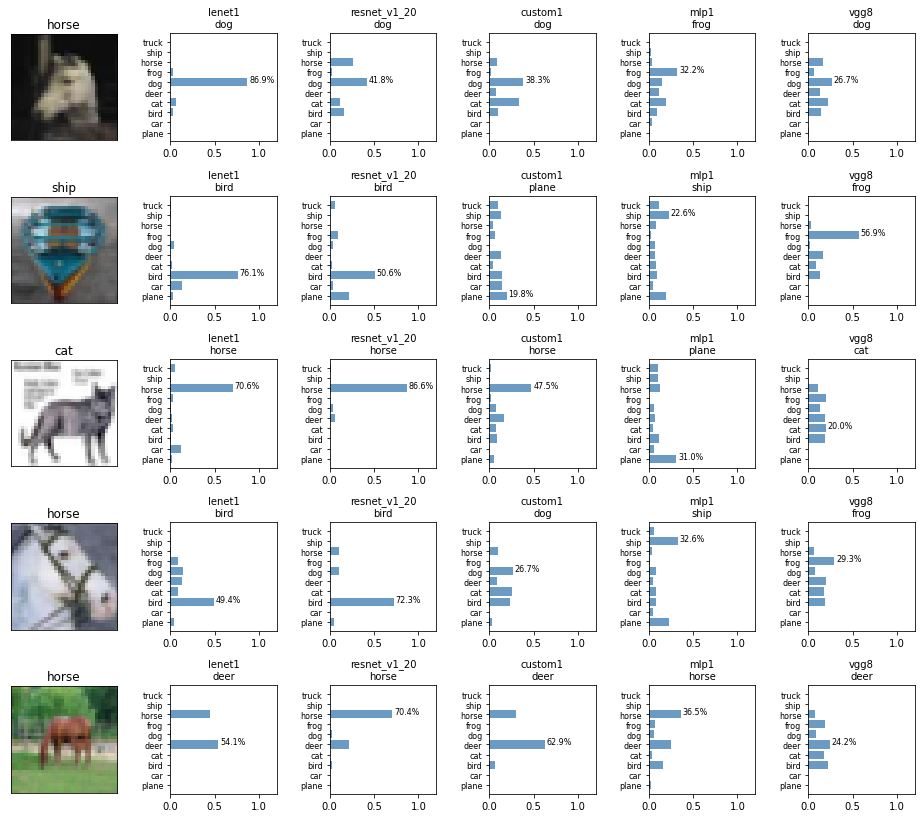

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,83170,1099.0,0.4480,0.7639,0.8460,0.7404,0.9878,0.9645
2,resnet_v1_20,273066,51.1,1.4243,1.4746,0.5483,0.5319,0.9320,0.9261
3,custom1,73738,12.4,1.4409,1.4617,0.4858,0.4729,0.8905,0.8868
4,mlp1,394634,505.6,1.7550,1.7995,0.3752,0.3531,0.8083,0.7939
5,vgg8,1672906,24.4,4.3419,4.3726,0.1832,0.1818,0.6803,0.6759


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

2021-08-10 09:13:24,972: INFO: model_params.custom1.dropout=0.2
2021-08-10 09:13:25,088: INFO: learning_rate=0.001
2021-08-10 09:13:25,089: INFO: model_params.custom1.clip_value=None
2021-08-10 09:13:25,095: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
2021-08-10 09:13:25,102: INFO: model_params.custom1.epochs=120
2021-08-10 09:13:25,102: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1, monitor=val_accuracy)
2021-08-10 09:13:25,103: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 09:13:25,104: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 09:13:25,105: INFO: use LearningRateScheduler()
2021-08-10 09:13:25,106: INFO: steps_per_epoch=1562


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
______________________________________________________________

2021-08-10 09:13:25,107: INFO: start training
2021-08-10 09:13:25,108: INFO: use_class_weight=False


Epoch 1/120
1562/1562 [==============================] - 16s 10ms/step - loss: 1.6164 - accuracy: 0.4152 - val_loss: 1.9429 - val_accuracy: 0.3707
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:13:43,635: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 2/120
1562/1562 [==============================] - 15s 9ms/step - loss: 1.2896 - accuracy: 0.5385 - val_loss: 1.4694 - val_accuracy: 0.4914
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:14:00,952: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 3/120
1562/1562 [==============================] - 15s 9ms/step - loss: 1.1499 - accuracy: 0.5929 - val_loss: 1.5689 - val_accuracy: 0.4989
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:14:18,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 4/120
1562/1562 [==============================] - 15s 9ms/step - loss: 1.0659 - accuracy: 0.6240 - val_loss: 1.2541 - val_accuracy: 0.5838
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:14:36,332: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 5/120
1562/1562 [==============================] - 12s 8ms/step - loss: 1.0012 - accuracy: 0.6477 - val_loss: 0.9954 - val_accuracy: 0.6525
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:14:50,912: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 6/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.9561 - accuracy: 0.6653 - val_loss: 1.0576 - val_accuracy: 0.6372
Epoch 7/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.9233 - accuracy: 0.6758 - val_loss: 1.2202 - val_accuracy: 0.6152
Epoch 8/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.8969 - accuracy: 0.6848 - val_loss: 0.9348 - val_accuracy: 0.6805
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:15:38,125: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 9/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.8757 - accuracy: 0.6946 - val_loss: 0.8456 - val_accuracy: 0.7035
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:15:55,839: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 10/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.8531 - accuracy: 0.7014 - val_loss: 0.8783 - val_accuracy: 0.7036
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:16:13,181: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 11/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.8363 - accuracy: 0.7089 - val_loss: 1.0276 - val_accuracy: 0.6562
Epoch 12/120
1562/1562 [==============================] - 14s 9ms/step - loss: 0.8186 - accuracy: 0.7145 - val_loss: 0.7805 - val_accuracy: 0.7342
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:16:44,967: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 13/120
1562/1562 [==============================] - 14s 9ms/step - loss: 0.8065 - accuracy: 0.7191 - val_loss: 0.8661 - val_accuracy: 0.7049
Epoch 14/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7912 - accuracy: 0.7252 - val_loss: 0.7724 - val_accuracy: 0.7335
Epoch 15/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7856 - accuracy: 0.7233 - val_loss: 1.0655 - val_accuracy: 0.6543
Epoch 16/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7746 - accuracy: 0.7303 - val_loss: 0.9475 - val_accuracy: 0.6780
Epoch 17/120
1562/1562 [==============================] - 15s 10ms/step - loss: 0.7641 - accuracy: 0.7329 - val_loss: 0.8697 - val_accuracy: 0.7052
Epoch 18/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7596 - accuracy: 0.7331 - val_loss: 0.9445 - val_accuracy: 0.6851
Epoch 19/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7565 - accuracy: 0.7326 - val_loss: 

2021-08-10 09:18:31,653: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 20/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7382 - accuracy: 0.7423 - val_loss: 0.8306 - val_accuracy: 0.7227
Epoch 21/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7359 - accuracy: 0.7431 - val_loss: 1.5673 - val_accuracy: 0.5511
Epoch 22/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7321 - accuracy: 0.7453 - val_loss: 0.8049 - val_accuracy: 0.7301
Epoch 23/120
1562/1562 [==============================] - 15s 10ms/step - loss: 0.7231 - accuracy: 0.7482 - val_loss: 0.7621 - val_accuracy: 0.7399
Epoch 24/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7179 - accuracy: 0.7480 - val_loss: 1.2331 - val_accuracy: 0.6245
Epoch 25/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7044 - accuracy: 0.7536 - val_loss: 0.7484 - val_accuracy: 0.7485
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/ou

2021-08-10 09:20:04,048: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 26/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7071 - accuracy: 0.7542 - val_loss: 0.7152 - val_accuracy: 0.7582
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:20:21,453: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 27/120
1562/1562 [==============================] - 15s 10ms/step - loss: 0.7035 - accuracy: 0.7533 - val_loss: 0.7964 - val_accuracy: 0.7378
Epoch 28/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.7038 - accuracy: 0.7539 - val_loss: 0.8432 - val_accuracy: 0.7175
Epoch 29/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6901 - accuracy: 0.7585 - val_loss: 0.8177 - val_accuracy: 0.7309
Epoch 30/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6891 - accuracy: 0.7594 - val_loss: 0.7736 - val_accuracy: 0.7416
Epoch 31/120
1562/1562 [==============================] - 15s 10ms/step - loss: 0.6841 - accuracy: 0.7599 - val_loss: 0.8165 - val_accuracy: 0.7319
Epoch 32/120
1562/1562 [==============================] - 12s 8ms/step - loss: 0.6789 - accuracy: 0.7626 - val_loss: 0.9007 - val_accuracy: 0.7035
Epoch 33/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6776 - accuracy: 0.7620 - val_loss:

2021-08-10 09:22:35,435: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 36/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6679 - accuracy: 0.7654 - val_loss: 0.7212 - val_accuracy: 0.7594
Epoch 37/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6646 - accuracy: 0.7681 - val_loss: 0.7354 - val_accuracy: 0.7522
Epoch 38/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6633 - accuracy: 0.7703 - val_loss: 0.7223 - val_accuracy: 0.7578
Epoch 39/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6541 - accuracy: 0.7697 - val_loss: 0.7132 - val_accuracy: 0.7608
Epoch 40/120
1562/1562 [==============================] - 15s 10ms/step - loss: 0.6536 - accuracy: 0.7708 - val_loss: 1.0016 - val_accuracy: 0.6809
Epoch 41/120
1562/1562 [==============================] - 15s 9ms/step - loss: 0.6539 - accuracy: 0.7708 - val_loss: 0.7123 - val_accuracy: 0.7581
Epoch 42/120
1562/1562 [==============================] - 13s 8ms/step - loss: 0.6523 - accuracy: 0.7725 - val_loss: 

2021-08-10 09:26:38,898: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 52/120
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 15s 10ms/step - loss: 0.5925 - accuracy: 0.7918 - val_loss: 0.6242 - val_accuracy: 0.7903
Epoch 53/120
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 15s 9ms/step - loss: 0.5843 - accuracy: 0.7948 - val_loss: 0.6339 - val_accuracy: 0.7880
Epoch 54/120
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 14s 9ms/step - loss: 0.5755 - accuracy: 0.7984 - val_loss: 0.6318 - val_accuracy: 0.7888
Epoch 55/120
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5770 - accuracy: 0.7979 - val_loss: 0.6180 - val_accuracy: 0.7922
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/cu

2021-08-10 09:27:41,237: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 56/120
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5727 - accuracy: 0.7979 - val_loss: 0.6526 - val_accuracy: 0.7820
Epoch 57/120
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5725 - accuracy: 0.7996 - val_loss: 0.6676 - val_accuracy: 0.7795
Epoch 58/120
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 20s 13ms/step - loss: 0.5703 - accuracy: 0.8006 - val_loss: 0.6653 - val_accuracy: 0.7775
Epoch 59/120
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 18s 11ms/step - loss: 0.5686 - accuracy: 0.8004 - val_loss: 0.6335 - val_accuracy: 0.7868
Epoch 60/120
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 19s 12ms/step - loss: 0.5

2021-08-10 09:29:16,135: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
1562/1562 [==============================] - 17s 11ms/step - loss: 0.5586 - accuracy: 0.8056 - val_loss: 0.6077 - val_accuracy: 0.7965
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:29:36,356: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 62/120
1562/1562 [==============================] - 20s 13ms/step - loss: 0.5564 - accuracy: 0.8049 - val_loss: 0.6040 - val_accuracy: 0.7971
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-08-10 09:29:58,680: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


Epoch 63/120
1562/1562 [==============================] - 16s 10ms/step - loss: 0.5597 - accuracy: 0.8037 - val_loss: 0.6022 - val_accuracy: 0.7969
Epoch 64/120
 192/1562 [==>...........................] - ETA: 15s - loss: 0.5778 - accuracy: 0.7998

### VGG

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [ ]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [ ]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

In [ ]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

In [ ]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [ ]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

In [ ]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

In [ ]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [ ]:
type(helper.datasets.train_dataset)